In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns


In [58]:
file_path = "data/train_FD004_processed.csv"
df = pd.read_csv(file_path)

In [59]:
max_rul = 130  # Typical cap for CMAPSS datasets
df['RUL'] = df['RUL'].clip(upper=max_rul)

In [60]:
WINDOW_SIZE = 30
FEATURE_COLS = [col for col in df.columns if col.startswith('op_setting_') or col.startswith('sensor_measurement_')]
TARGET_COL = 'RUL'

In [61]:
scaler_features = StandardScaler()
scaler_target = StandardScaler()

In [62]:
df[FEATURE_COLS] = scaler_features.fit_transform(df[FEATURE_COLS])
df[TARGET_COL] = scaler_target.fit_transform(df[[TARGET_COL]])


In [63]:
def create_sequences(data, window_size, feature_cols, target_col):
    X, y = [], []
    for unit in data['unit_number'].unique():
        unit_data = data[data['unit_number'] == unit]
        feature_data = unit_data[feature_cols].values
        target_data = unit_data[target_col].values
        for i in range(len(unit_data) - window_size):
            X.append(feature_data[i:i+window_size])
            y.append(target_data[i+window_size])
    return np.array(X), np.array(y)

In [64]:
X, y = create_sequences(df, WINDOW_SIZE, FEATURE_COLS, TARGET_COL)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
input_shape = X.shape[1:]  
latent_dim = 64

In [66]:
inputs = Input(shape=input_shape)
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2, padding='same')(x)  # Reduces from 30 to 15
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
# x = MaxPooling1D(pool_size=2, padding='same')(x)  # Reduces from 15 to 8 (with padding)
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu', name='latent')(x)

In [67]:
x = Dense(8 * 24)(encoded)  
x = Reshape((8, 24))(x)  
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling1D(size=2)(x)  
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling1D(size=2)(x) 
x = Conv1D(filters=24, kernel_size=3, activation='relu', padding='same')(x)  

x = tf.keras.layers.Cropping1D(cropping=(1, 1))(x) 
decoded = Conv1D(filters=input_shape[-1], kernel_size=3, activation='linear', padding='same')(x) 


In [68]:
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 30, 32)         │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 15, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 192)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 8, 64)          │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 16, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 32, 24)         │         2,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_2 (Cropping1D)       │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 30, 24)         │         1,752 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,456 (380.69 KB)

 Trainable params: 97,456 (380.69 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.5927 - val_loss: 0.1780
Epoch 2/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.1518 - val_loss: 0.1222
Epoch 3/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.1198 - val_loss: 0.1123
Epoch 4/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.1076 - val_loss: 0.1072
Epoch 5/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0963 - val_loss: 0.0888
Epoch 6/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.0855 - val_loss: 0.0807
Epoch 7/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0796 - val_loss: 0.0793
Epoch 8/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0754 - val_loss: 0.0787
Epoch 9/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.0722 - val_loss: 0.0678
Epoch 10/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0689 - val_loss: 0.0686
Epoch 11/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0670 - val_loss: 0.0745
Epoch 12

In [70]:
encoder = Model(inputs, encoded)

In [71]:
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)

X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], X_train_encoded.shape[1], 1)
X_val_encoded = X_val_encoded.reshape(X_val_encoded.shape[0], X_val_encoded.shape[1], 1)


1345/1345 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [73]:
print("Encoded train shape:", X_train_encoded.shape)


Encoded train shape: (43023, 64, 1)


IndexError: index 1 is out of bounds for axis 1 with size 1

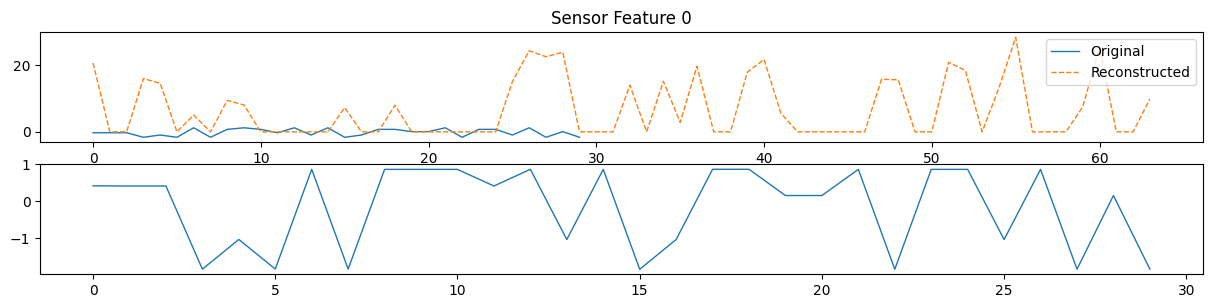

In [72]:


sample_idx = np.random.randint(0, X_val.shape[0])
original = X_val[sample_idx]
reconstructed = X_val_encoded[sample_idx]

num_sensors_to_plot = 6 
plt.figure(figsize=(15, 10))
for i in range(num_sensors_to_plot):
    plt.subplot(num_sensors_to_plot, 1, i + 1)
    plt.plot(original[:, i], label='Original', linewidth=1)
    plt.plot(reconstructed[:, i], label='Reconstructed', linestyle='--', linewidth=1)
    plt.title(f'Sensor Feature {i}')
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
recon_errors = np.mean(np.square(X_val - decoded_val), axis=(0, 1))  # MSE per feature
for i, err in enumerate(recon_errors):
    print(f"Sensor {i}: MSE = {err:.4f}")


In [41]:
lstm_inputs = Input(shape=(X_train_encoded.shape[1], X_train_encoded.shape[2]))
x = LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm_inputs)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

In [42]:
lstm_model = Model(lstm_inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
lstm_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 16, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,561 (510.00 KB)

 Trainable params: 130,561 (510.00 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [44]:
history = lstm_model.fit(
    X_train_encoded, y_train,
    validation_data=(X_val_encoded, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/50
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - loss: 1.0902 - mae: 0.9015 - val_loss: 1.0305 - val_mae: 0.9052 - learning_rate: 0.0050
Epoch 2/50
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 1.0343 - mae: 0.9033 - val_loss: 1.0286 - val_mae: 0.9012 - learning_rate: 0.0050
Epoch 3/50
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 1.0412 - mae: 0.9070 - val_loss: 1.0288 - val_mae: 0.9019 - learning_rate: 0.0050
Epoch 4/50
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - loss: 1.0403 - mae: 0.9050 - val_loss: 1.0283 - val_mae: 0.8998 - learning_rate: 0.0050
Epoch 5/50
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 1.0371 - mae: 0.9030 - val_loss: 1.0284 - val_mae: 0.9003 - learning_rate: 0.0050
Epoch 6/50
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - loss: 1.0361 - mae: 0.9028 - val_loss: 1.0291 - val_mae: 0.8928 - learning_rate: 0.0050
Epoch 7/50
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 1.0442 - mae: 0.9062 - val_loss: 1.0312 - val_mae: 0.9072 - 

In [45]:
y_pred = lstm_model.predict(X_val_encoded)
y_val_inv = scaler_target.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_pred_inv = scaler_target.inverse_transform(y_pred).flatten()

337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [46]:
mse = mean_squared_error(y_val_inv, y_pred_inv)
mae = mean_absolute_error(y_val_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_val_inv, y_pred_inv)
medae = median_absolute_error(y_val_inv, y_pred_inv)

In [47]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Median Absolute Error: {medae:.2f}")

MAE: 38.24
MSE: 1864.39
RMSE: 43.18
R² Score: -0.0000
MAPE: 32736401901197.36%
Median Absolute Error: 39.02


In [55]:
decoded_val = autoencoder.predict(X_val)
mse_recon = np.mean(np.square(X_val - decoded_val))
print("Autoencoder Validation Reconstruction MSE:", mse_recon)


337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Autoencoder Validation Reconstruction MSE: 0.4132452455098305


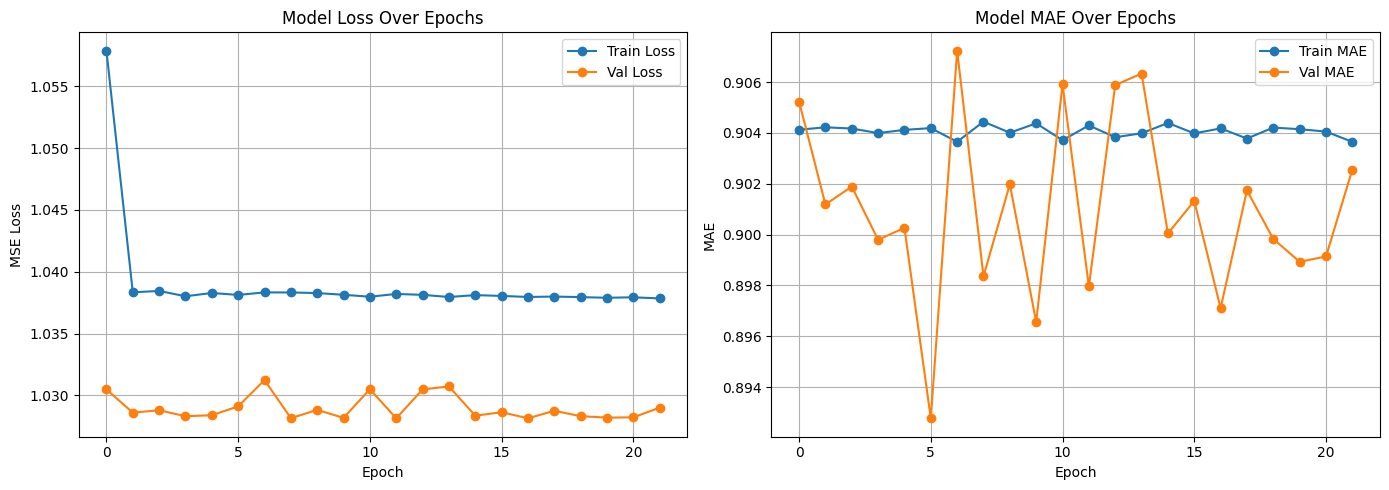

In [54]:
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', marker='o')
plt.plot(history.history['val_mae'], label='Val MAE', marker='o')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [49]:
# errors = y_val_inv - y_pred_inv
# plt.figure(figsize=(10, 6))
# sns.histplot(errors, bins=50, kde=True, color='blue')
# plt.title('Distribution of RUL Prediction Errors (Lightweight LSTM)')
# plt.xlabel('Prediction Error (Actual RUL - Predicted RUL)')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.savefig('lightweight_prediction_error_distribution.png')
# plt.close()

In [50]:
# unit_ids = df['unit_number'].unique()
# sample_unit = unit_ids[0]
# unit_data = df[df['unit_number'] == sample_unit]
# unit_X, unit_y = create_sequences(unit_data, WINDOW_SIZE, selected_features, target_col)
# unit_pred = lstm_model.predict(unit_X)
# unit_y_inv = scaler_target.inverse_transform(unit_y.reshape(-1, 1)).flatten()
# unit_pred_inv = scaler_target.inverse_transform(unit_pred).flatten()


In [51]:
# plt.figure(figsize=(12, 6))
# plt.plot(unit_y_inv, label='Actual RUL', marker='o')
# plt.plot(unit_pred_inv, label='Predicted RUL', marker='x')
# plt.title(f'RUL Prediction for Unit {sample_unit} (Lightweight LSTM)')
# plt.xlabel('Cycle')
# plt.ylabel('RUL')
# plt.legend()
# plt.grid(True)
# plt.savefig('lightweight_lstm_temporal_prediction_plot.png')
# plt.close()

In [52]:
# cumulative_error = np.cumsum(np.abs(errors))
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_error, color='red')
# plt.title('Cumulative Absolute Prediction Error (Lightweight LSTM)')
# plt.xlabel('Sample Index')
# plt.ylabel('Cumulative Absolute Error')
# plt.grid(True)
# plt.savefig('lightweight_cumulative_error_plot.png')
# plt.close()

In [53]:
# lstm_model.save("models/autoencoder_lstm_rul_model.keras")